In [154]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arabic-names/all_arabic_names.txt


In [155]:
words = open('../input/arabic-names/all_arabic_names.txt', 'r').read().splitlines()
len(words)

10692

In [156]:
# Tokenize characters by assigning them numerical value
# '.' is special value to indicate beginning/end of name

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [157]:
itos

{1: ' ',
 2: ',',
 3: 'ء',
 4: 'آ',
 5: 'أ',
 6: 'ؤ',
 7: 'إ',
 8: 'ئ',
 9: 'ا',
 10: 'ب',
 11: 'ة',
 12: 'ت',
 13: 'ث',
 14: 'ج',
 15: 'ح',
 16: 'خ',
 17: 'د',
 18: 'ذ',
 19: 'ر',
 20: 'ز',
 21: 'س',
 22: 'ش',
 23: 'ص',
 24: 'ض',
 25: 'ط',
 26: 'ظ',
 27: 'ع',
 28: 'غ',
 29: 'ف',
 30: 'ق',
 31: 'ك',
 32: 'ل',
 33: 'م',
 34: 'ن',
 35: 'ه',
 36: 'و',
 37: 'ى',
 38: 'ي',
 39: 'ً',
 40: 'ٌ',
 41: 'ٍ',
 42: 'َ',
 43: 'ُ',
 44: 'ِ',
 45: 'ّ',
 46: 'ْ',
 47: 'ٰ',
 0: '.'}

In [158]:
# train/val/dev split = 80/10/10
def build_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    #         print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

In [159]:
import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xval, Yval = build_dataset(words[n2:])

torch.Size([51241, 3]) torch.Size([51241])
torch.Size([6446, 3]) torch.Size([6446])
torch.Size([6503, 3]) torch.Size([6503])


In [160]:
C = torch.randn((48, 10))
W1 = torch.randn((30, 256))
b1 = torch.randn(256)
W2 = torch.randn((256, 48))
b2 = torch.randn(48)

params = [C, W1, b1, W2, b2]

In [161]:
sum(p.nelement() for p in params)

20752

In [162]:
for p in params:
    p.requires_grad = True

In [163]:
lri = []
losses = []
steps = []

In [164]:
for i in range(100000):
    # mini-batching
    ix = torch.randint(0, Xtr.shape[0], (64,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = emb.view(emb.shape[0], emb.shape[1] * emb.shape[2]) @ W1 + b1
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    print(loss.item())
    # backward pass
#     lr = lrs[i]
    lr = 0.1 if i < 50000 else 0.01
    
    for p in params:
        p.grad = None
    
    loss.backward()

    for p in params:
        p.data += -lr * p.grad
        
#     track stats
    losses.append(loss.log10().item()) #  just plotting loss can give graph hockey stick appearance, log squashes it
    steps.append(i)
#     if loss.item() < 1000:
#         lri.append(lre[i])
#         losses.append(loss.item())

185.27670288085938
134.82901000976562
152.8638153076172
99.36144256591797
106.51275634765625
117.3486328125
81.75253295898438
88.70159912109375
66.14482879638672
55.83827590942383
74.80484008789062
90.6504898071289
61.656829833984375
64.42312622070312
59.051666259765625
49.58208084106445
64.1047592163086
69.4063720703125
37.753482818603516
49.003665924072266
53.401615142822266
46.39731216430664
51.25927734375
42.99455261230469
34.792911529541016
36.81329345703125
32.483741760253906
42.24217987060547
26.12449836730957
33.863365173339844
27.911720275878906
32.507450103759766
48.234012603759766
41.80833435058594
19.718996047973633
24.395740509033203
26.34296226501465
22.741695404052734
22.138364791870117
29.743444442749023
28.078529357910156
22.803136825561523
30.244705200195312
25.552936553955078
24.903060913085938
25.323673248291016
20.525203704833984
20.90959930419922
18.95844841003418
19.444902420043945
18.12175750732422
16.61001968383789
36.06696701049805
20.0454158782959
22.55978393

In [165]:
loss.item()

2.4853594303131104

In [166]:
emb = C[Xdev]
h = emb.view(emb.shape[0], emb.shape[1] * emb.shape[2]) @ W1 + b1
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.5494720935821533

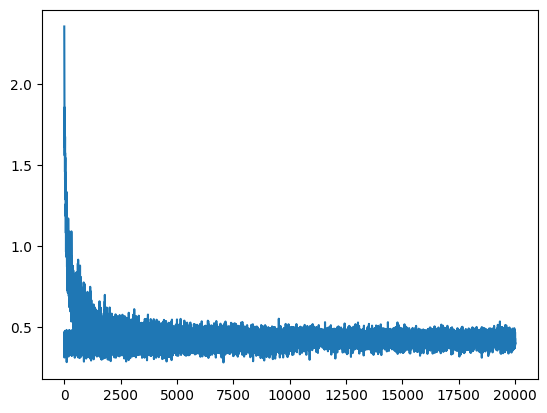

In [142]:
# plt.plot(steps, losses)

In [167]:
emb = C[Xval]
h = emb.view(emb.shape[0], emb.shape[1] * emb.shape[2]) @ W1 + b1
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.5303, grad_fn=<NllLossBackward0>)

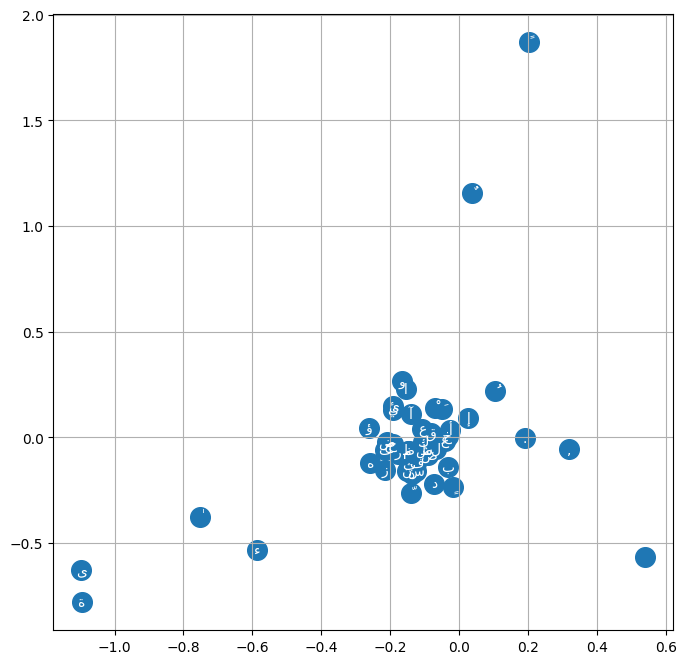

In [104]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [168]:
# sample from the model
g = torch.Generator()

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

مجرايسه.
انم.
مطدورى نبل.
شطاك.
مزواهنية.
معسداءىٌظنظ بشرويمتدي.
سائوت.
رمانجهيل.
دائريفاجاكوثة.
ميزانيسر.
أمش ملتيا.
غجي.
بلرانى.
لشاه.
حنمزعى.
جوضةىشتشرفه.
جعيستيف.
سبد.
حمدادىردكنود.
ضعضىءٌةعضىأذشهرنحنيها.
